<a href="https://colab.research.google.com/github/iamNabeelMughal/Sentiment-Analysis-of-Amazon-Reviews/blob/main/Amazon_product_rev_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

### Import Libraries

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 13.0 GB  | Proc size: 120.4 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
!cat AmazonTest.csv

cat: AmazonTest.csv: No such file or directory


In [ ]:
from google.colab import files

import pandas as pd

uploaded = files.upload()


In [ ]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8918587393353594048
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1677682844802303436
physical_device_desc: "device: XLA_CPU device"
]


In [ ]:
import re
import string
import scipy
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score 
#from prettytable import PrettyTable
from astropy.table import Table, Column

In [ ]:
train_file_path = 'AmazonTrain4.csv'
test_file_path = 'AmazonTest4.csv'

In [ ]:
train_dataset = pd.read_csv(r"AmazonTrain.csv")
test_dataset = pd.read_csv(r"AmazonTest.csv")

### Understand Data

In [ ]:
print("Train Dataset:\n")

train_dataset.index.names = ['index']
train_dataset.columns.name = train_dataset.index.name
train_dataset.index.name = None
print(train_dataset)

Train Dataset:

index  positive  Useful for remodels: I recently remodeled my house and these came in extremely useful for boring through studs for electrical and plumbing... as well as prepping doors for hardware.
0      positive   decent get what u pay for: I got this set for...                                                                                                                                    
1      positive   Rock solid: Perfect solution - stable and acc...                                                                                                                                    
2      positive   Fun, humorous, and touching!: I highly recomm...                                                                                                                                    
3      positive   Horror that isn't for the faint-hearted: Of t...                                                                                                                          

In [ ]:
print("\n\n\nTrain Dataset Columns:\n")
print(train_dataset.columns)
print("\n\n\nNumber of instances in Train Dataset:\n")
print("Train instances: ", train_dataset.shape[0])




Train Dataset Columns:

Index(['positive', ' Useful for remodels: I recently remodeled my house and these came in extremely useful for boring through studs for electrical and plumbing... as well as prepping doors for hardware.'], dtype='object', name='index')



Number of instances in Train Dataset:

Train instances:  29999


In [ ]:
print("\n\n\nTest Dataset\n")
test_dataset.index.names = ['index']
test_dataset.columns.name = test_dataset.index.name
test_dataset.index.name = None
print(test_dataset)




Test Dataset

index Sentiment                                             Phrase
0      negative   Throwing away dollars: The first one I receiv...
1      negative   Charging only (will not sync): Be forewarned,...
2      negative   Not a real apple cable: This isn't a real app...
3      negative   Unreliable Merchant: Ordered this item. My ca...
4      negative   Poor: I bought 3 of these. I thought I will j...
5      negative   Doesn't charge iPhone: It doesn't charge my i...
6      negative   The cables do not work well: The cables do no...
7      negative   NOT the real deal: Contrary to what is advert...
8      negative   This is not the product shown in the picture....
9      negative   Buyer Beware - Not as advertised: This cable ...
10     negative   HORRIBLE!: I bought this because my old cord ...
11     negative   Nice Connector....but....: This is a nice con...
12     positive   Worth the money: Since im always loosing my c...
13     negative   WORKS WITH ELECTRICAL OUTLE

In [ ]:
print("\n\n\nTest Dataset Columns:\n")
print(test_dataset.columns)
print("\n\n\nNumber of instances in Test Dataset:\n")
print("Test instances: ", test_dataset.shape[0])




Test Dataset Columns:

Index(['Sentiment', 'Phrase'], dtype='object', name='index')



Number of instances in Test Dataset:

Test instances:  10000


In [ ]:
train_positive = train_dataset[train_dataset['Sentiment'] ==1]
train_negative = train_dataset[train_dataset['Sentiment'] ==0]
print("Reviews 'Positive' in Train Dataset:\n")
train_positive.index.names = ['index']
train_positive.columns.name = train_positive.index.name
train_positive.index.name = None
print(train_positive)

KeyError: ignored

In [ ]:
test_positive = test_dataset[test_dataset['Sentiment'] ==1]
test_negative = test_dataset[test_dataset['Sentiment'] ==0]
print("Reviews 'Positive' in Test Dataset:\n")
test_positive.index.names = ['index']
test_positive.columns.name = test_positive.index.name
test_positive.index.name = None
print(test_positive)

Reviews 'Positive' in Test Dataset:

Empty DataFrame
Columns: [Sentiment, Phrase]
Index: []


In [ ]:
print("Reviews 'Negative' in Test Dataset:\n")
test_negative.index.names = ['index']
test_negative.columns.name = test_negative.index.name
test_negative.index.name = None
print(test_negative)

Reviews 'Negative' in Test Dataset:

Empty DataFrame
Columns: [Sentiment, Phrase]
Index: []


In [ ]:
train_positive_words = pd.Series(''.join(train_positive['Phrase'].astype(str)).lower().split(" ")).value_counts()

train_negative_words = pd.Series(''.join(train_negative['Phrase'].astype(str)).lower().split(" ")).value_counts()

NameError: ignored

In [ ]:
print("\n\n\nWords used 'Positive' in train data:\n")
print("Words Count\n")
print(train_positive_words)




Words used 'Positive' in train data:

Words Count



NameError: ignored

In [ ]:
print("\n\n\nWords used 'Negative' in train data:\n")
print("Words Count\n")
print(train_negative_words)




Words used 'Negative' in train data:

Words Count



NameError: ignored

In [ ]:
test_positive_words = pd.Series(''.join(train_positive['Phrase'].astype(str)).lower().split(" ")).value_counts()

test_negative_words = pd.Series(''.join(train_negative['Phrase'].astype(str)).lower().split(" ")).value_counts()

In [ ]:
print("\n\n\nWords used 'Positive' in test data:\n")
print("Words Count\n")
print(test_positive_words)




Words used 'Positive' in test data:

Words Count

    1
dtype: int64


In [ ]:
print("\n\n\nWords used 'Negative' in test data:\n")
print("Words Count\n")
print(test_negative_words)




Words used 'Negative' in test data:

Words Count

    1
dtype: int64


Bar graph of words used 'Positive' in train data



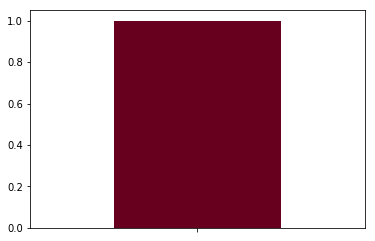

In [ ]:
print("Bar graph of words used 'Positive' in train data\n")
train_positive_words.head(20).plot(kind='bar',stacked=True,colormap='RdGy')

Bar graph of words used 'Negative' in train data



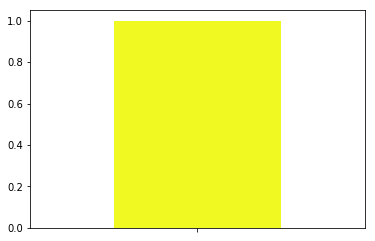

In [ ]:
print("Bar graph of words used 'Negative' in train data\n")
train_negative_words.head(20).plot(kind='bar',stacked=True,colormap='plasma_r')

Bar graph of words used 'Positive' in test data



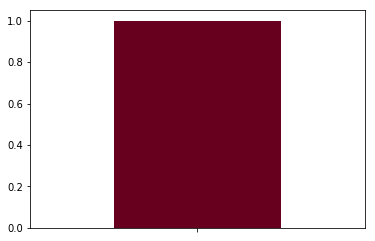

In [ ]:
print("Bar graph of words used 'Positive' in test data\n")
test_positive_words.head(20).plot(kind='bar',stacked=True,colormap='RdGy')

Bar graph of words used 'Negative' in test data



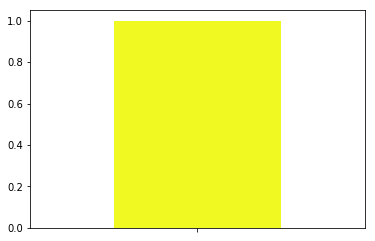

In [ ]:
print("Bar graph of words used 'Negative' in test data\n")
test_negative_words.head(20).plot(kind='bar',stacked=True,colormap='plasma_r')

### Pre-Process Data

In [ ]:
train_dataset=train_dataset.fillna(' ')
test_dataset=test_dataset.fillna(' ')

In [ ]:
print("Train dataset before pre-processing:\n")
train_dataset.index.names=['index']
train_dataset.columns.name=train_dataset.index.name
train_dataset.index.name=None
print(train_dataset)

Train dataset before pre-processing:

index Sentiment                                             Phrase
0      positive   Useful for remodels: I recently remodeled my ...
1      positive   decent get what u pay for: I got this set for...
2      positive   Rock solid: Perfect solution - stable and acc...
3      positive   Fun, humorous, and touching!: I highly recomm...
4      positive   Horror that isn't for the faint-hearted: Of t...
5      positive   master and margarita fully filmed: after read...
6      positive   Love these pens: I started writing with these...
7      negative   Bill: liar, draft dodger, amoral, our Prez .....
8      negative   not even close...: I was very let down by thi...
9      positive   nice little camera: easy to carry, easy to sh...
10     positive   Where is EUCLID?: I know little about the per...
11     negative   Better to Stay Medievalist than Becoming Bad ...
12     positive   Great guitar for the price: I bought the S35 ...
13     positive   Great 

In [ ]:
print("Test dataset before pre-processing:\n")
test_dataset.index.names=['index']
test_dataset.columns.name=test_dataset.index.name
test_dataset.index.name=None
print(test_dataset)

Test dataset before pre-processing:

index Sentiment                                             Phrase
0      negative   Throwing away dollars: The first one I receiv...
1      negative   Charging only (will not sync): Be forewarned,...
2      negative   Not a real apple cable: This isn't a real app...
3      negative   Unreliable Merchant: Ordered this item. My ca...
4      negative   Poor: I bought 3 of these. I thought I will j...
5      negative   Doesn't charge iPhone: It doesn't charge my i...
6      negative   The cables do not work well: The cables do no...
7      negative   NOT the real deal: Contrary to what is advert...
8      negative   This is not the product shown in the picture....
9      negative   Buyer Beware - Not as advertised: This cable ...
10     negative   HORRIBLE!: I bought this because my old cord ...
11     negative   Nice Connector....but....: This is a nice con...
12     positive   Worth the money: Since im always loosing my c...
13     negative   WORKS W

In [ ]:
def remove_punctuation(phrase):
    phrase = re.sub(r'[^\x00-x7f]',r' ',phrase)
    return re.sub("["+string.punctuation+"]"," ",phrase)

In [ ]:
def normalize_text(phrase):
   phrase=phrase.strip()
   phrase=phrase.lower() 
   phrase=re.sub('[\s0-9]',' ',phrase)
   return phrase

In [ ]:
train_dataset['Phrase'] = train_dataset['Phrase'].map(remove_punctuation)

train_dataset['Phrase'] = train_dataset['Phrase'].map(normalize_text)

test_dataset['Phrase'] = test_dataset['Phrase'].map(remove_punctuation)

test_dataset['Phrase'] = test_dataset['Phrase'].map(normalize_text)

In [ ]:
print("\n\n\nTrain dataset after pre-processing:\n")
train_dataset.index.names=['index']
train_dataset.columns.name=train_dataset.index.name
train_dataset.index.name=None
print(train_dataset)




Train dataset after pre-processing:

index Sentiment                                             Phrase
0      positive  useful for remodels  i recentl  remodeled m  h...
1      positive  decent get what u pa  for  i got this set for ...
2      positive  rock solid  perfect solution   stable and acce...
3      positive  fun  humorous  and touching   i highl  recomme...
4      positive  horror that isn t for the faint hearted  of th...
5      positive  master and margarita full  filmed  after readi...
6      positive  love these pens  i started writing with these ...
7      negative  bill  liar  draft dodger  amoral  our pre     ...
8      negative  not even close     i was ver  let down b  this...
9      positive  nice little camera  eas  to carr   eas  to sho...
10     positive  where is euclid   i know little about the peri...
11     negative  better to sta  medievalist than becoming bad c...
12     positive  great guitar for the price  i bought the s   f...
13     positive  great

In [ ]:
print("\n\n\nTest dataset after pre-processing:\n")
test_dataset.index.names=['index']
test_dataset.columns.name=test_dataset.index.name
test_dataset.index.name=None
print(test_dataset)




Test dataset after pre-processing:

index Sentiment                                             Phrase
0      negative  throwing awa  dollars  the first one i receive...
1      negative  charging onl   will not s nc   be forewarned  ...
2      negative  not a real apple cable  this isn t a real appl...
3      negative  unreliable merchant  ordered this item  m  car...
4      negative  poor  i bought   of these  i thought i will ju...
5      negative  doesn t charge iphone  it doesn t charge m  ip...
6      negative  the cables do not work well  the cables do not...
7      negative  not the real deal  contrar  to what is adverti...
8      negative  this is not the product shown in the picture  ...
9      negative  bu er beware   not as advertised  this cable i...
10     negative  horrible   i bought this because m  old cord  ...
11     negative  nice connector    but      this is a nice conn...
12     positive  worth the mone   since im alwa s loosing m  ch...
13     negative  works 

### Lable Encoding for Test/Train Data

In [ ]:
labelEncoder = LabelEncoder()

classes = ['positive','negative']

labelEncoder.fit(classes)

LabelEncoder()

In [ ]:
train_class_encoding = pd.DataFrame(labelEncoder.transform(train_dataset.Sentiment),columns = ['encoded_sentiment'])

print("Train Dataset Labels Encoding:\n")
label_encoding = train_dataset.assign(encoded_sentiment = train_class_encoding)

print(label_encoding)

Train Dataset Labels Encoding:

index Sentiment                                             Phrase  \
0      positive  useful for remodels  i recentl  remodeled m  h...   
1      positive  decent get what u pa  for  i got this set for ...   
2      positive  rock solid  perfect solution   stable and acce...   
3      positive  fun  humorous  and touching   i highl  recomme...   
4      positive  horror that isn t for the faint hearted  of th...   
5      positive  master and margarita full  filmed  after readi...   
6      positive  love these pens  i started writing with these ...   
7      negative  bill  liar  draft dodger  amoral  our pre     ...   
8      negative  not even close     i was ver  let down b  this...   
9      positive  nice little camera  eas  to carr   eas  to sho...   
10     positive  where is euclid   i know little about the peri...   
11     negative  better to sta  medievalist than becoming bad c...   
12     positive  great guitar for the price  i bought the 

In [ ]:
test_class_encoding = pd.DataFrame(labelEncoder.transform(test_dataset.Sentiment),columns = ['encoded_sentiment'])

print("Test Dataset Labels Encoding:\n")
label_encoding = test_dataset.assign(encoded_sentiment = test_class_encoding)

print(label_encoding)

Test Dataset Labels Encoding:

index Sentiment                                             Phrase  \
0      negative  throwing awa  dollars  the first one i receive...   
1      negative  charging onl   will not s nc   be forewarned  ...   
2      negative  not a real apple cable  this isn t a real appl...   
3      negative  unreliable merchant  ordered this item  m  car...   
4      negative  poor  i bought   of these  i thought i will ju...   
5      negative  doesn t charge iphone  it doesn t charge m  ip...   
6      negative  the cables do not work well  the cables do not...   
7      negative  not the real deal  contrar  to what is adverti...   
8      negative  this is not the product shown in the picture  ...   
9      negative  bu er beware   not as advertised  this cable i...   
10     negative  horrible   i bought this because m  old cord  ...   
11     negative  nice connector    but      this is a nice conn...   
12     positive  worth the mone   since im alwa s loosing m

### Feature Extraction - Changing Representation of Data "from String to Vector"

In [ ]:
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(2,2),
  
    )

print("Paramenters of TFIDF Vectorizer and its values:\n\n")

print(vect)

Paramenters of TFIDF Vectorizer and its values:


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)


In [ ]:
all_data =pd.concat([train_dataset,test_dataset])
vect = vect.fit(all_data.Phrase)
all_features = vect.transform(all_data.Phrase)
test=all_features[train_dataset.shape[0]:]
train=all_features[:train_dataset.shape[0]]


In [ ]:
print("\n\n\nCheck shape of the Features:\n\n")

print("Train Features Shape:",train.shape)

print("Test Features Shape:",test.shape)





Check shape of the Features:


Train Features Shape: (4999, 185207)
Test Features Shape: (1499, 185207)


In [ ]:
train_features_df = pd.DataFrame(train.toarray(),columns = vect.get_feature_names())

test_features_df = pd.DataFrame(test.toarray(),columns = vect.get_feature_names())


In [ ]:
print("\n\n\nTrain Features Before Assigning a 'Sentiment' Column:\n")
train_features_df.index.names = ['index']
train_features_df.columns.name = train_features_df.index.name
train_features_df.index.name = None
print(train_features_df)




Train Features Before Assigning a 'Sentiment' Column:

index  aa batter  aa batteries  aa makes  aaaaaaaaaaaaaaaaaaaaaaaa greeeeaaat  \
0            0.0           0.0       0.0                                  0.0   
1            0.0           0.0       0.0                                  0.0   
2            0.0           0.0       0.0                                  0.0   
3            0.0           0.0       0.0                                  0.0   
4            0.0           0.0       0.0                                  0.0   
5            0.0           0.0       0.0                                  0.0   
6            0.0           0.0       0.0                                  0.0   
7            0.0           0.0       0.0                                  0.0   
8            0.0           0.0       0.0                                  0.0   
9            0.0           0.0       0.0                                  0.0   
10           0.0           0.0       0.0           

In [ ]:
print("\n\n\nTest Features Before Assigning a 'Sentiment' Column:\n")
test_features_df.index.names = ['index']
test_features_df.columns.name = train_features_df.index.name
test_features_df.index.name = None
print(test_features_df)




Test Features Before Assigning a 'Sentiment' Column:

      aa batter  aa batteries  aa makes  aaaaaaaaaaaaaaaaaaaaaaaa greeeeaaat  \
0           0.0           0.0       0.0                                  0.0   
1           0.0           0.0       0.0                                  0.0   
2           0.0           0.0       0.0                                  0.0   
3           0.0           0.0       0.0                                  0.0   
4           0.0           0.0       0.0                                  0.0   
5           0.0           0.0       0.0                                  0.0   
6           0.0           0.0       0.0                                  0.0   
7           0.0           0.0       0.0                                  0.0   
8           0.0           0.0       0.0                                  0.0   
9           0.0           0.0       0.0                                  0.0   
10          0.0           0.0       0.0                        

In [ ]:
train_features_df=train_features_df.assign(Sentiment=train_class_encoding)

test_features_df=test_features_df.assign(Sentiment=test_class_encoding)

print("\n\n\nTrain Features after Assigning a 'Sentiment' Column:\n")

print(train_features_df)

NameError: ignored

In [ ]:
print("\n\n\nTest Features after Assigning a 'Sentiment' Column:\n")

print(test_features_df)




Test Features after Assigning a 'Sentiment' Column:

       aa  aaa  aaaaaaaaaaaaaaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa  \
0     0.0  0.0                       0.0                                 0.0   
1     0.0  0.0                       0.0                                 0.0   
2     0.0  0.0                       0.0                                 0.0   
3     0.0  0.0                       0.0                                 0.0   
4     0.0  0.0                       0.0                                 0.0   
5     0.0  0.0                       0.0                                 0.0   
6     0.0  0.0                       0.0                                 0.0   
7     0.0  0.0                       0.0                                 0.0   
8     0.0  0.0                       0.0                                 0.0   
9     0.0  0.0                       0.0                                 0.0   
10    0.0  0.0                       0.0                        

In [ ]:
print("\nTrain Features shape:",train_features_df.shape)
print("\nTest Features shape:",test_features_df.shape)



Train Features shape: (10001, 35081)

Test Features shape: (2999, 35081)


In [ ]:
train_encoded_labels = train_features_df[['Sentiment']]

test_encoded_labels = test_features_df[['Sentiment']]

train_features = train_features_df.drop(['Sentiment'],axis=1)


test_features = test_features_df.drop(['Sentiment'],axis=1)


sparse_train_features = scipy.sparse.csr_matrix(train_features_df.values)

sparse_test_features = scipy.sparse.csr_matrix(test_features_df.values)




### Train Machine Learning Algorithms using Training Data


### Random Forest

In [ ]:
random_forest_classifier = RandomForestClassifier()
print("Paramenters and their values:\n")
print(random_forest_classifier)
random_forest_classifier.fit(sparse_train_features,np.ravel(train_encoded_labels))


In [ ]:
scores=[]
print("Before Prediction using Random Forest Classifier:\n")
print(test_dataset)
y_pred = random_forest_classifier.predict(sparse_test_features)
score = round(accuracy_score(test_encoded_labels,y_pred),2)

inverse_transform = labelEncoder.inverse_transform(y_pred)
print("\n\n\nAfter Prediction using Random Forest Classifier:\n")
print(test_dataset.assign(predicted_sentiment = inverse_transform))
print("\n\nAccuracy score= ",score)
scores.append(score)

### Application Phase

In [ ]:
all_features = pd.concat([train_features,test_features])
labels = pd.concat([train_encoded_labels,test_encoded_labels])
print("All Features Dataframe with Labels/output:\n")
all_features.index.names=['index']
all_features.columns.name=all_features.index.name
all_features.index.name=None
all_features=scipy.sparse.csr_matrix(all_features.values)
#print(all_features.assign(Sentiment=labels))

In [ ]:
random_forest_classifier.fit(all_features,np.ravel(labels))

In [ ]:
pickle.dump(random_forest_classifier, open('RandomForestClassifier.pkl','wb'))

In [ ]:
classifier=pickle.load(open('RandomForestClassifier.pkl','rb'))

In [ ]:
user_input=input("Please enter your Review here: ").strip()


Please enter your Review here: this is for the first time that I have bought a product online and I am highly disappointed.


In [ ]:
data=[user_input]
transformed_input=vect.transform(data)
print("\n\nVector features: ",vect.get_feature_names(),"\n\n")
user_input_features=pd.DataFrame(transformed_input.toarray(),
columns=vect.get_feature_names())
print("\n\nUser input features with weights\n\n",user_input_features,"\n\n")



Vector features:  ['aa batteries', 'ab smal', 'abbott costello', 'able bu', 'able cd', 'able connect', 'able control', 'able enjo', 'able game', 'able hear', 'able listen', 'able look', 'able make', 'able pla', 'able read', 'able s', 'able tell', 'able use', 'able work', 'able write', 'absolute beginners', 'absolute best', 'absolute favorite', 'absolute worst', 'absolutel ama', 'absolutel awful', 'absolutel beautiful', 'absolutel best', 'absolutel fascinating', 'absolutel hilarious', 'absolutel horrible', 'absolutel love', 'absolutel loved', 'absolutel loves', 'absolutel perfect', 'absolutel wonderful', 'abuse book', 'abuse child', 'ac adapter', 'ac adaptor', 'ac dc', 'access internet', 'accompan ing', 'accompanied b', 'according m', 'acoustic alchem', 'acoustic guitar', 'act like', 'acting bad', 'acting just', 'acting like', 'action figure', 'action movie', 'action movies', 'action ou', 'action packed', 'actors film', 'acts like', 'actual product', 'actuall bought', 'actuall did', '

In [ ]:
print("\n\nPrediction: ",end='')
pred=classifier.predict(transformed_input)

if(pred==1):
    print("Positive")

if(pred==0):
    print("Negative")
        



Prediction: Positive
